# Notebook for exercise 2

## 0. Get data ready

In [2]:
# Import the necessary libraries
import os   #helps me erase a warning that i am getting
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler  #need this for standardizing the data
from sklearn.decomposition import PCA #need this for the PCA in the data
import torch
from torch import nn #need this for my model (layers, loss functions, ...)
from sklearn.metrics import accuracy_score #need this to measure the accuracy of the model
import time  #need this to calcualate the training time
from pathlib import Path #need this for the save_model(). 
import matplotlib.pyplot as plt  # need this for the model's plots
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

In [3]:
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



In [4]:
pca = PCA(n_components = 0.92)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"X_train_pca.shape = {X_train_pca.shape}")
print(f"X_test_pca.shape = {X_test_pca.shape}")


X_train_pca.shape = (50000, 131)
X_test_pca.shape = (10000, 131)


In [5]:
y_train2 = []
X_train2 = []
y_test2 = []
X_test2 = []

#For training
for idx,value in enumerate(y_train):
    if value == 0 or value == 1:
        y_train2.append(value)
        X_train2.append(X_train[idx,:])

X_train2=np.array(X_train2)
y_train2=np.array(y_train2)

#For testing 
for idx,value in enumerate(y_test):
    if value == 0 or value == 1:
        y_test2.append(value)
        X_test2.append(X_test[idx,:])

X_test2=np.array(X_test2)
y_test2=np.array(y_test2)




print(f"X_train2.shape = {X_train2.shape}")
print(f"y_train2.shape = {y_train2.shape}")
print(f"X_test2.shape = {X_test2.shape}")
print(f"y_test2.shape = {y_test2.shape}")

X_train2.shape = (10000, 3072)
y_train2.shape = (10000,)
X_test2.shape = (2000, 3072)
y_test2.shape = (2000,)


In [6]:
pca = PCA(n_components = 0.92)
scaler = StandardScaler()

X_train2_pca = pca.fit_transform(X_train2)
X_test2_pca = pca.transform(X_test2)

X_train2_sc_pca = scaler.fit_transform(X_train2_pca)
X_test2_sc_pca = scaler.transform(X_test2_pca)

print(f"X_train_pca.shape = {X_train2_sc_pca.shape}")
print(f"X_test_pca.shape = {X_test2_sc_pca.shape}")

X_train_pca.shape = (10000, 125)
X_test_pca.shape = (2000, 125)


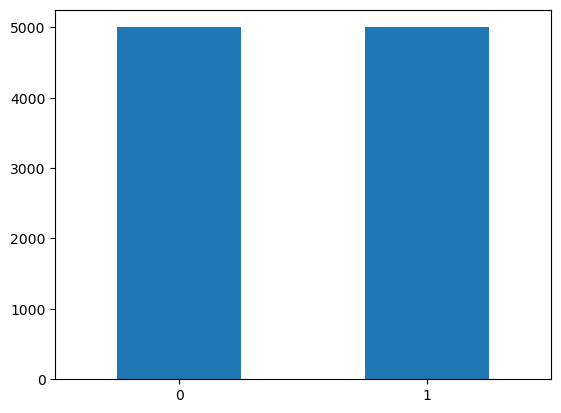

In [28]:
pd.Series(y_train2).value_counts().sort_index().plot(kind='bar', rot=0);

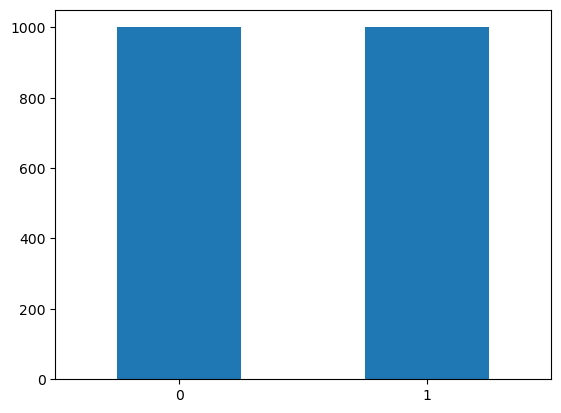

In [29]:
pd.Series(y_test2).value_counts().sort_index().plot(kind='bar', rot=0);

In [7]:
# svms_b_acc = []

def train_test_svm(model,X_train,X_test,y_train,y_test):
    start_time = time.time()
    
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    end_time=time.time()

    b_acc = balanced_accuracy_score(y_test,y_pred)

    print(f"Total time: {(end_time-start_time):.2f}s | Test Balanced accuracy: {round(b_acc*100,2):.2f}%")

    return round(b_acc*100,2)






In [31]:
svm_v0 = SVC()
b_acc = train_test_svm(svm_v0,X_train_pca,X_test_pca,y_train,y_test)


print(f"SVMv1 balanced accuracy: {b_acc}")


Total time: 490.3570101261139
SVMv1 balanced accuracy: 53.84


IT TAKES TO MUCH TIME. SO FROM NOW ON I WILL WORK WITH ONLY 2 CLASSES

In [44]:
svm_v1 = SVC()
b_acc = train_test_svm(svm_v1,X_train2_sc_pca,X_test2_sc_pca,y_train2,y_test2)


Total time: 7.98s | Test Balanced accuracy: 90.60%


In [11]:
svm_v2 = SVC(kernel='poly',degree=5)
b_acc = train_test_svm(svm_v2,X_train2_sc_pca,X_test2_sc_pca,y_train2,y_test2)


Total time: 15.25s | Test Balanced accuracy: 51.50%


In [ ]:
param_grid={
    "kernel":["poly","rbf"],
    "degree":[2,3,4], 
}

grid_search = GridSearchCV(SVC(),param_grid,cv=3,scoring=balanced_accuracy_score,n_jobs=-1,verbose=4, return_train_score=True)

grid_search.fit(X_train,y_train)

print(f"\nBest parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_




y_pred_best = best_svm.predict(X_test)
best_acc = balanced_accuracy_score(y_test,y_pred_best)
print(f"best balanced accuracy: {best_acc}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(
C:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(



Best parameters: {'degree': 2, 'kernel': 'poly'}


PCA AND STANDARD SCALE THE X

- The maximum margin classifier forms the basis of SVMs, searating classes with the widest posssible gap to ensure stability and robustness.
This stability under perturbations makes it a <u>**powerful choice**</u> for tasks where <u>**small changes in data are common**</u>

- SVMs are by definition two-class classifiers.

- In scenarios where the number of classes (c > 2), Support Vector Machines (SVMs) can be extended to handle multiclass classification using two common approaches:
1. One-vs-the-Rest Approach
Train one SVM model for each class. For class i, the SVM distinguishes between class i and all other classes.

2. One-vs-One Approach
Train c(c-1)/2 binary SVM models, each for a pair of classes (one-vs-one).
For a given input the predicted class is determined by **majority voting**, i.e., the class that receives the highest number of "votes" across all pairwise models is selected.


# AN DO OTI PAIRNIE POLY ORA NA TREJEI MPORO NA KRATISO MONO 2 CLASSES ETSI OSTE NA TREXEI PIO GRIGORA KAI NA DOKIIMAZO PERISSOTERA PRAGMATA